For this assignment, I took pictures of one of the most popular spots in Berlin, Bradenburg Gate. I took some pictures while walking around the gate. I took majority of the pictures by fixing the camera in the nearby Starbucks and taking timelapses throughout the day.

In [1]:
%matplotlib inline

import cv2
import matplotlib.pyplot as plt
import random
from glob import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import time

In [2]:
# Loading all the pictures
photos_files = glob('photos/*')

Original Image:


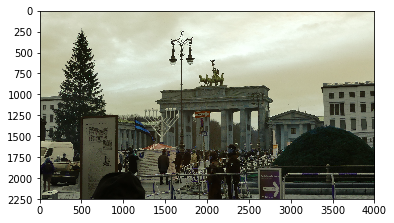

Resized image at 512*512 pixels


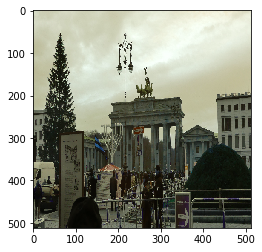

Resized image at 150*150 pixels


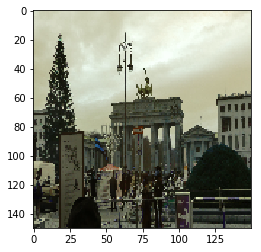

In [3]:
def show_pic(pic_array, normalize=True):
    img = pic_array
    if normalize:
        img = cv2.normalize(resize_img, alpha = 0.0, beta = 1.0, \
                              dst = resize_img, dtype=cv2.CV_32F, \
                              norm_type=cv2.NORM_MINMAX)
    plt.imshow(img)
    plt.show()

print('Original Image:')
test_image = cv2.imread(photos_files[0])
show_pic(test_image, False)


print('Resized image at 512*512 pixels')
resize_img = cv2.resize(src = test_image, dsize = (512, 512))
show_pic(resize_img, False)



print('Resized image at 150*150 pixels')
resize_img = cv2.resize(src = test_image, dsize = (150, 150))
show_pic(resize_img, False)


I am resizing images to 150x150 pixels to decrease the image size for faster processing. Even at this size, the image has not lost majority of its features.

In [4]:
# Converting image files to numpy array

img_width = 150
img_height = 150

photos_arr = []
for photo in photos_files:
    try:
        img = cv2.imread(photo)
        resize_img = cv2.resize(src = img, dsize = (img_width, img_height))
        normalize_img = cv2.normalize(resize_img, alpha = 0.0, beta = 1.0, \
                                      dst = resize_img, dtype=cv2.CV_32F, \
                                      norm_type=cv2.NORM_MINMAX)
        photos_arr.append(normalize_img)
    except:
        continue        

In [5]:
# Flattening the img arrays to single dimension for training PCA model
photos_flat_arr = []

for photo_arr in photos_arr:
    photos_flat_arr.append(photo_arr.flatten())

In [6]:
# Fitting the datapoints to PCA model
pca = PCA(n_components = 2)
pca.fit(photos_flat_arr)

# Transforming data points using PCA model
pca_X = pca.transform(photos_flat_arr)

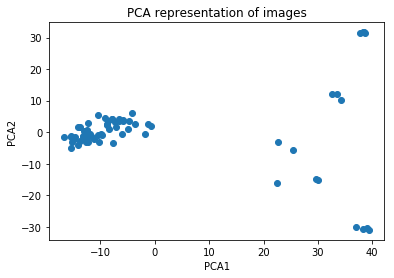

In [8]:
# Plotting the PCA values
plt.scatter(pca_X[:, 0], pca_X[:, 1])
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('PCA representation of images')
plt.show()

As seen in the plot above, most of the images are grouped around (-10, 0) in the 2-D PCA scales. So, I printed the original images far from the grouped images along with images to find the differences.

Indexes of far away images: [2, 3, 4, 5, 6, 11, 12, 13, 18, 19, 26, 27, 54, 55, 63, 64]
Images far away from the grouped images: 


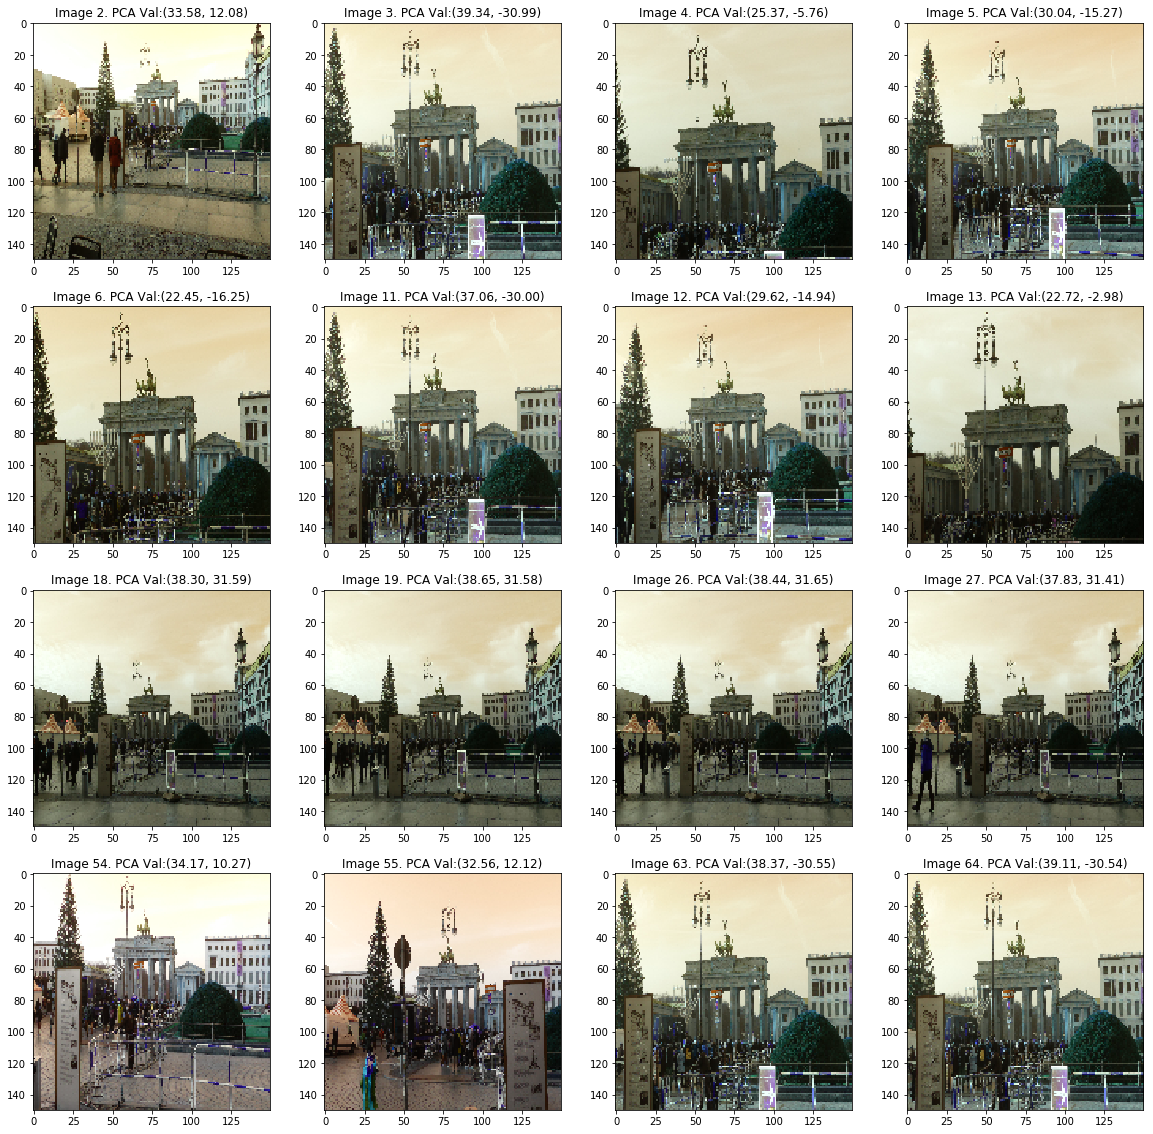

--------------------------------------------------
Images grouped together


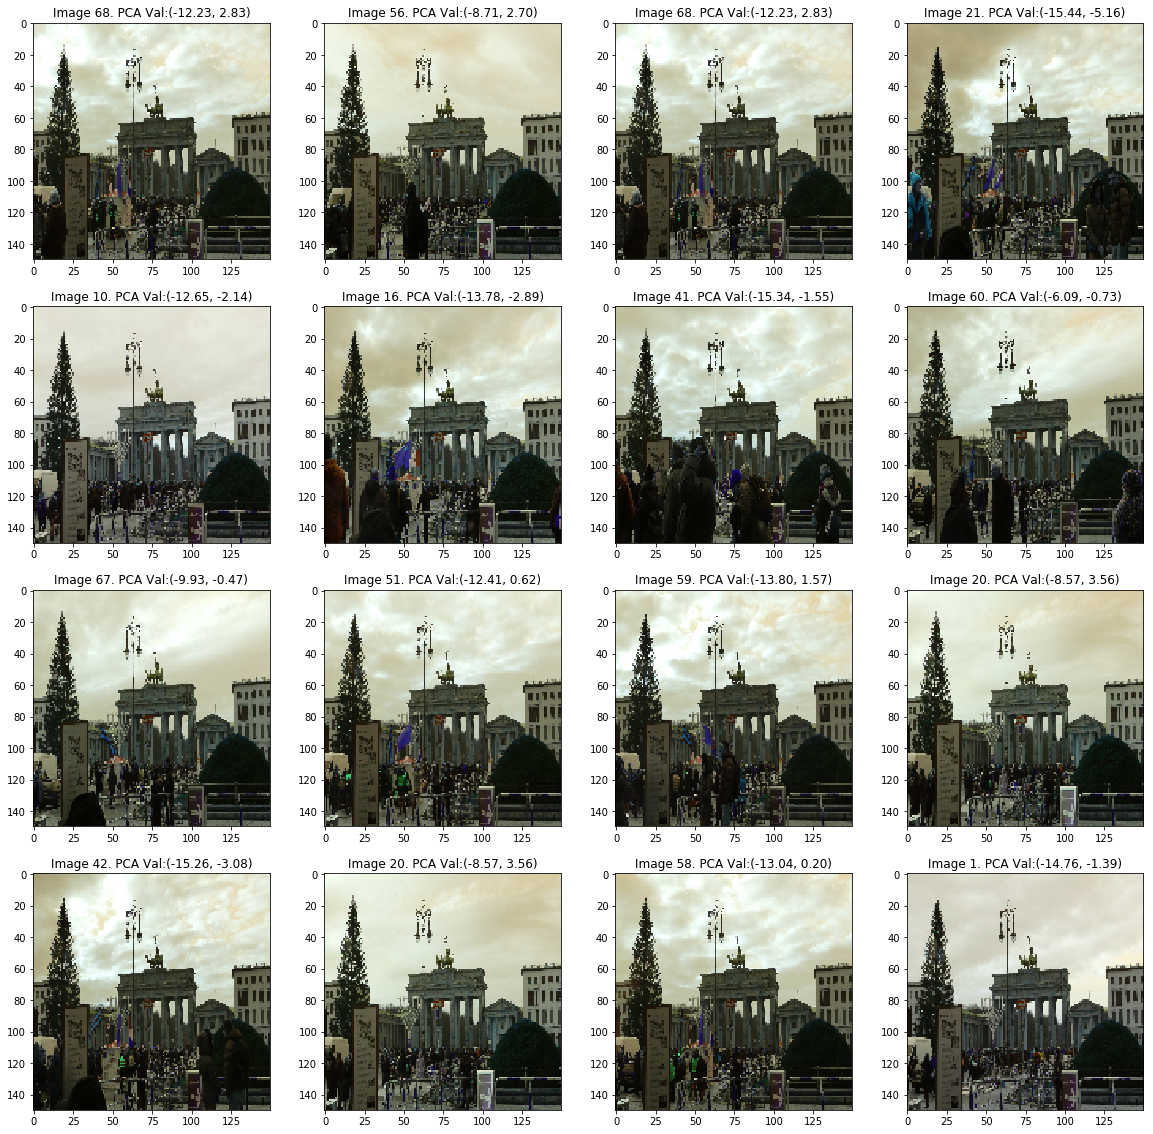

In [11]:
# Dividing the images into two categories
i = 0
far_indexes = []
for pca_val in pca_X:
    # finding values greater than 10 as, all those images are far apart.
    if pca_val[0] > 20:
        far_indexes.append(i)
    i += 1
print('Indexes of far away images: {0}'.format(far_indexes))

def show_img_collage(x_size, y_size, ind_range):
    f, axarr = plt.subplots(x_size, y_size, figsize=(20,20))
    i = 0
    j = 0
    for ind in ind_range:
        img_arr = photos_arr[ind]
        axarr[i, j].imshow(img_arr)
        axarr[i, j].set_title('Image {0}. PCA Val:({1:.2f}, {2:.2f})'.format(ind, pca_X[ind][0], pca_X[ind][1]))   
        j += 1
        if j == y_size:
            j = 0
            i += 1
    plt.show()
            
print('Images far away from the grouped images: ')
show_img_collage(int(len(far_indexes)/4), int(len(far_indexes)/4), far_indexes)

grouped_indexes = list(set(range(len(photos_arr)))-set(far_indexes))
print('-'*50)
print('Images grouped together')
show_img_collage(4, 4, np.random.choice(grouped_indexes, 16))

On analyzing these photos, I found out that the images that are grouped together are part of the same timelapse group pictures that the camera automatically took every few minutes. The images that are far apart have been manually taken. These pictures have a wider angle, whereas the grouped image are zoomed in and focused at the Brandenburg Tor.

## Plotting reconstructions of the images

Reconstructions of pictures far away in PCA plot
Choosen Images:: [ 3 19 18  2]
------------------------------------------------------------
------------------------------------------------------------
Original Image


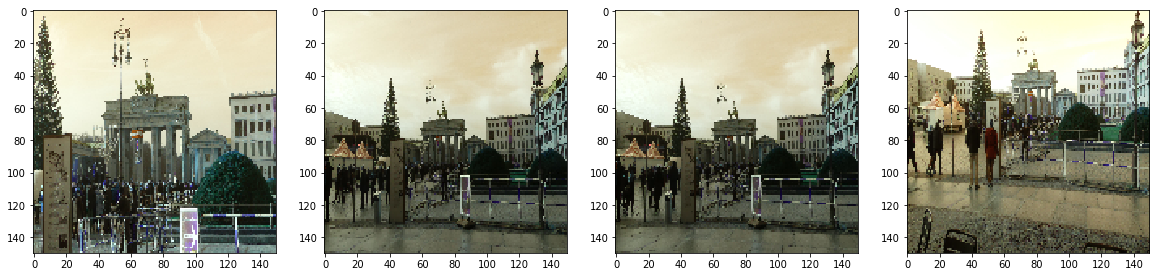

Reconstructed Image


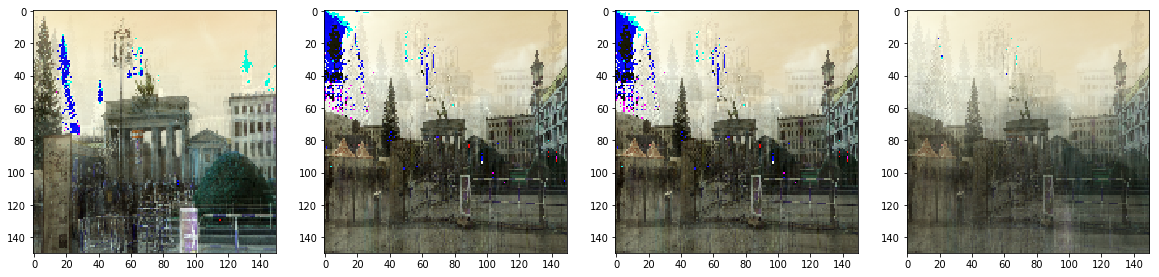

------------------------------------------------------------
------------------------------------------------------------
Reconstructions of pictures grouped in PCA plot
Choosen Images:: [33 42 61 47]
------------------------------------------------------------
------------------------------------------------------------
Original Image


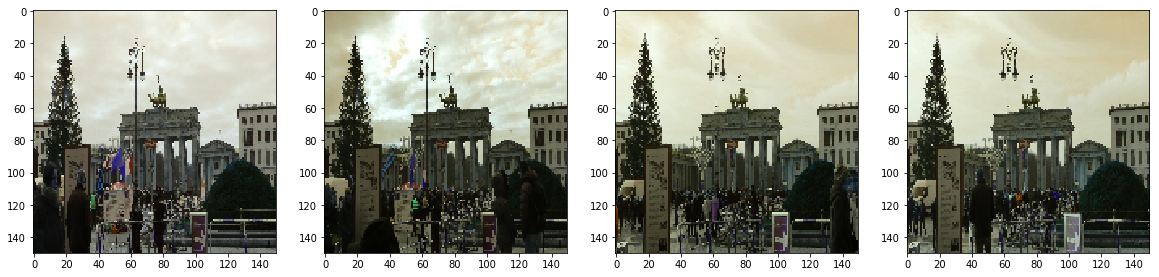

Reconstructed Image


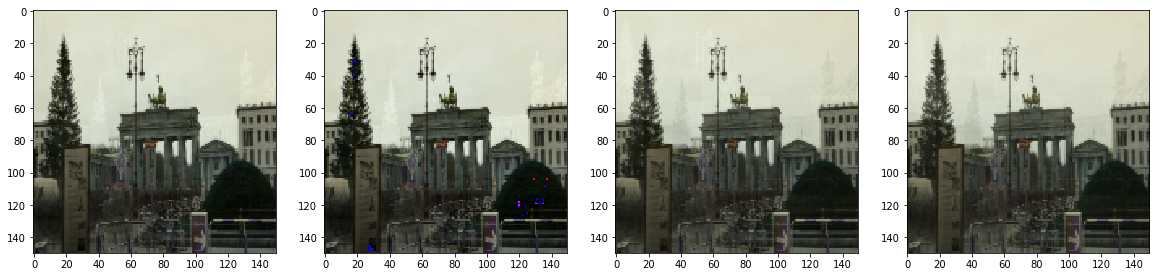

------------------------------------------------------------
------------------------------------------------------------
Reconstructions of pictures grouped in PCA plot
Choosen Images:: [20 22 31  7]
------------------------------------------------------------
------------------------------------------------------------
Original Image


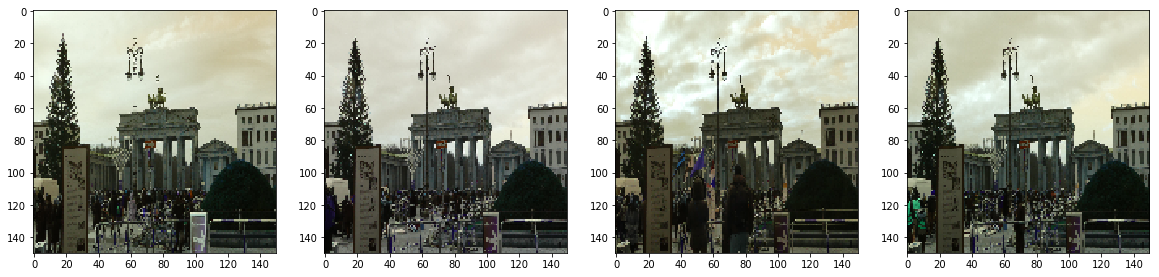

Reconstructed Image


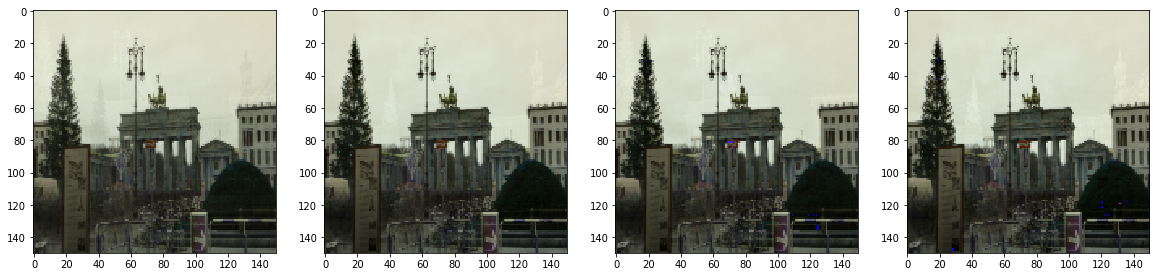

------------------------------------------------------------
------------------------------------------------------------


In [12]:
def show_reconstruct_img(pca, pca_X, ind_arr):
    '''
    Inputs:
        pca -> PCA_model
        pca_X -> array with PCA values
        ind_arr -> Indexes of images to be taken
    Assumes:
        photos_arr -> The array that consists of pixel values 
        for original images
    
    '''
    print('Choosen Images::', ind_arr)

    # Original Image
    print('---'*20)
    print('---'*20)
    print('Original Image')
    fig = plt.figure(figsize=(20,20))
    
    # Plotting the original images
    for i in range(1, 5):
        ind = ind_arr[i-1]
        img_arr = photos_arr[ind]
        ax = fig.add_subplot(2, 4, i)
        ax.imshow(img_arr)
    plt.show()
    
    # Reconstructed Image
    print('Reconstructed Image')
    fig = plt.figure(figsize=(20,20))
    
    # Plotting the constructed images
    for i in range(1, 5):
        ind = ind_arr[i-1]
        img_arr = reconstruct_img(pca, pca_X[ind])
        ax = fig.add_subplot(1, 4, i)
        ax.imshow(img_arr)
    plt.show()
    
    print('---'*20)
    print('---'*20)
    
    
def reconstruct_img(pca, pca_val):
    '''
    Inputs:
        pca -> PCA model
        pca_val -> array with values in PCA axes
    Returns:
        - Reconstructed array of pixels from the given PCA values.
        - The array is of shape (150, 150, 3) 
    '''
    
    X_inverse = pca.inverse_transform(pca_val)
    X_inverse = (X_inverse * 255).astype(np.uint8)
    X_inverse = X_inverse.reshape(img_width,img_height,3)
    return(X_inverse)

print('Reconstructions of pictures far away in PCA plot')
inds = np.random.choice(far_indexes, 4, replace=False)
show_reconstruct_img(pca, pca_X, inds)


print ('Reconstructions of pictures grouped in PCA plot')
inds = np.random.choice(grouped_indexes, 8, replace=False)
show_reconstruct_img(pca, pca_X, inds[:4])

print ('Reconstructions of pictures grouped in PCA plot')
show_reconstruct_img(pca, pca_X, inds[4:])

As shown earlier, the reconstruction of grouped images are better and more closer to their actual images compared to images which were placed further away in the PCA plot. As the people in the picture are not the major part, PCA is not using people in pictures for differentiating the pictures. We can see that in the reconstructions of pictures with people, where the people have been removed.
If we have many pictures with people of a landmark where there is high volume of people moving, we could combine all those images with people using PCA to reconstruct the image of only having the landmark.

## Plotting a point far away from known location in the PCA plot
I manually picked the four points that are far away from the known points.

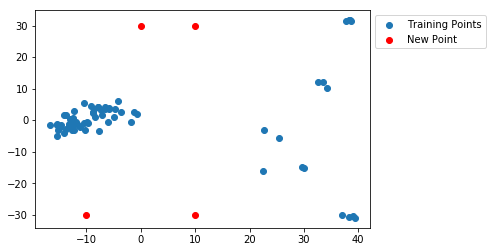

Reconstructed Image of new points


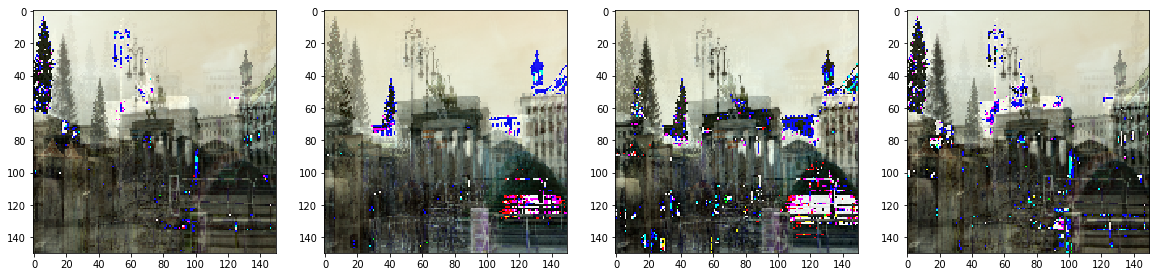

In [13]:
# Plot the known points
plt.scatter(pca_X[:, 0], pca_X[:, 1], label='Training Points')

# New points
new_point_x = [10, 10, -10, 0]
new_point_y = [30, -30, -30, 30]

# Ploting the old points
plt.scatter(new_point_x, new_point_y, color='red', label='New Point')
plt.legend(loc='best', bbox_to_anchor=(1, 1), ncol=1)
plt.show()

print('Reconstructed Image of new points')
fig = plt.figure(figsize=(20,20))
for i in range(1, 5):
    img_arr = reconstruct_img(pca, (new_point_x[i-1], new_point_y[i-1]))
    ax = fig.add_subplot(1, 4, i)
    ax.imshow(img_arr)
plt.show()

The reconstructed images from the new points far away from known points are distorted. They look like a layer of two different images which might be due to using two PCAs. 

# Doing it in 3D

In [15]:
# In three dimensions
# Fitting the datapoints to PCA model
pca3D = PCA(n_components = 3)
pca3D.fit(photos_flat_arr)

# Transforming data points using PCA model
pca_X_3D = pca3D.transform(photos_flat_arr)

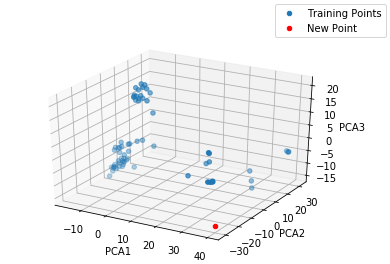

In [16]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(pca_X_3D[:, 0], pca_X_3D[:, 1], pca_X_3D[:, 2], 
           depthshade=True, label='Training Points')

new_point = (40, -30, -15)
ax.scatter(new_point[0], new_point[1], new_point[2], 
           depthshade=True, color='red', label='New Point')

ax.set_xlabel('PCA1', fontsize=10)
ax.set_ylabel('PCA2', fontsize='medium')
ax.set_zlabel('PCA3', fontsize='medium')
fig.legend()

As seen in above plot, the images are in three different groups. A group of images are spread through the region where PCA 1 > 0. Another group of images lie around (-20, 10, -15). The other group of images have PCA 3 > 0. I randomly picked images from each group to see the differences.

In [18]:
# Dividing images into three different groups based on their location
i = 0
g1_indexes = []
g2_indexes = []
g3_indexes = []
for pca_val in pca_X_3D:
    # finding values greater than 20 as, all those images are far apart.
    if pca_val[0] > 0:
        g1_indexes.append(i)
    elif 0 < pca_val[1] < 20:
        g2_indexes.append(i)
    if pca_val[2] > 0:
        g3_indexes.append(i)
    i += 1

Reconstructions of pictures with PCA1 > 0
Choosen Images:: [19 27  6  5]
------------------------------------------------------------
------------------------------------------------------------
Original Image


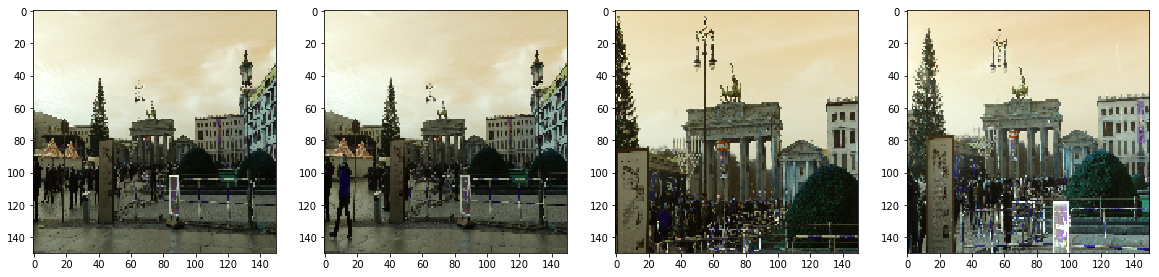

Reconstructed Image


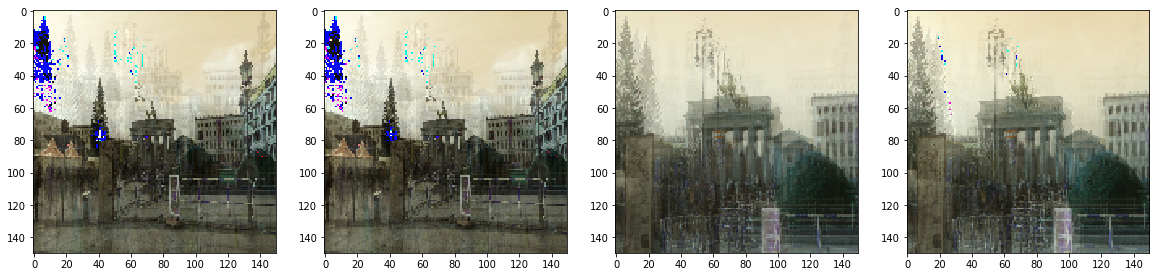

------------------------------------------------------------
------------------------------------------------------------
Reconstructions of pictures near (-20, 10, -15)
Choosen Images:: [59 46  8 38]
------------------------------------------------------------
------------------------------------------------------------
Original Image


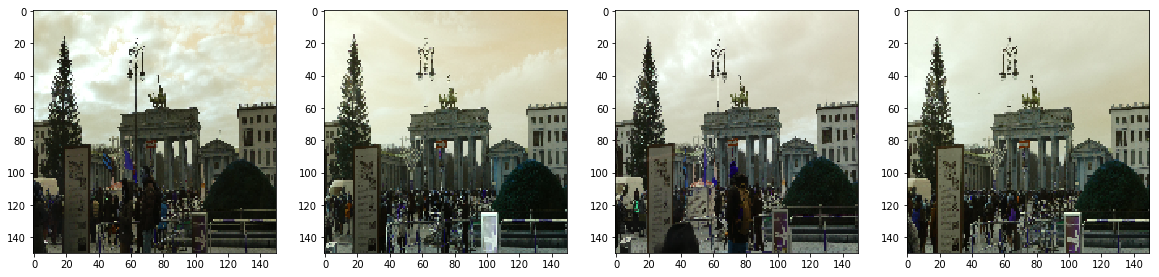

Reconstructed Image


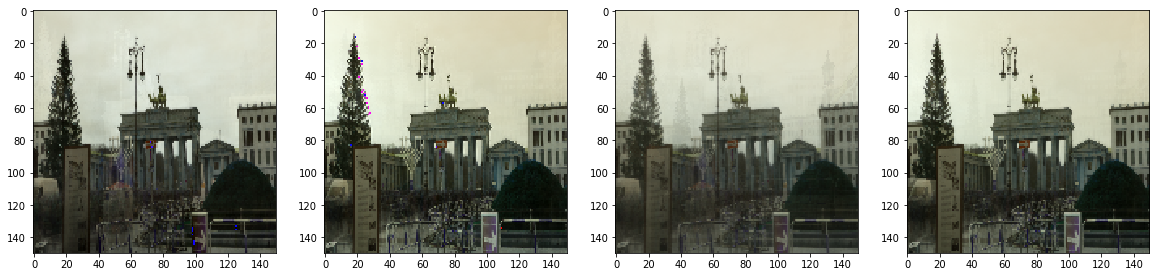

------------------------------------------------------------
------------------------------------------------------------
Reconstructions of pictures with PCA3 > 0
Choosen Images:: [34 52 45 11]
------------------------------------------------------------
------------------------------------------------------------
Original Image


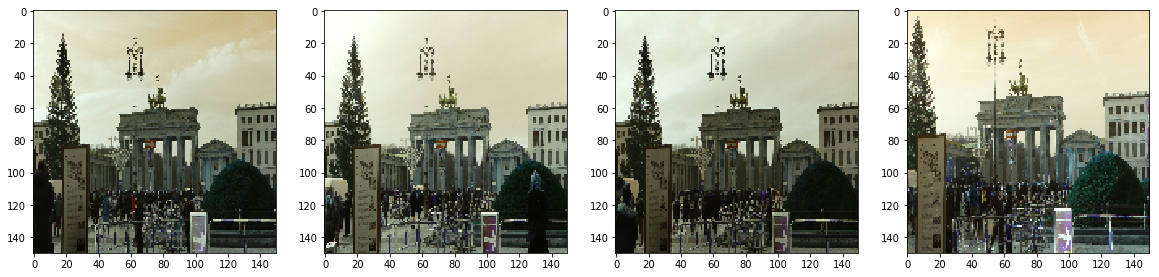

Reconstructed Image


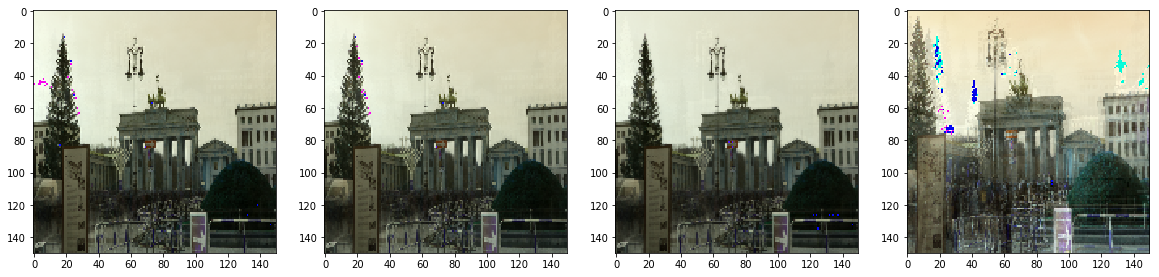

------------------------------------------------------------
------------------------------------------------------------


In [19]:
# Plotting original and reconstruction of the image
print('Reconstructions of pictures with PCA1 > 0')
inds = np.random.choice(g1_indexes, 4, replace=False)
show_reconstruct_img(pca3D, pca_X_3D, inds)

print('Reconstructions of pictures near (-20, 10, -15)')
inds = np.random.choice(g2_indexes, 4, replace=False)
show_reconstruct_img(pca3D, pca_X_3D, inds)

print('Reconstructions of pictures with PCA3 > 0')
inds = np.random.choice(g3_indexes, 4, replace=False)
show_reconstruct_img(pca3D, pca_X_3D, inds)

The group that is far spread with PCA 1 > 0, has the worse reconstrution. These images are taken manually from different places.
The other two groups resemble two different group of timelapse. One was taken in the morning and the other was taken during the the afternoon. Both of the images were taken from a camera fixed to a table in the Starbucks.
Based on these observation, PCA 3 is considering the brightness in the picture to differentiate.

Reconstructed Image of new point


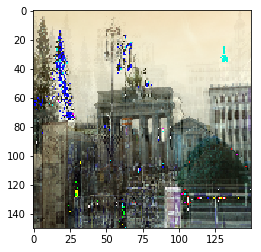

In [20]:
print('Reconstructed Image of new point')
img_arr = reconstruct_img(pca3D, new_point)
plt.imshow(img_arr)
plt.show()